# Impacto de los indicadores bursatiles en la implementacion de arbol de decisiones. 

## Librerias 

In [72]:
#pip install scikit-learn
#%pip install xgboost
#%pip install shap
#%pip install pandas

In [73]:
# Manipulacion de datos
import numpy as np
import pandas as pd

# Extacción de datos.
#import eikon as ek
#import refinitiv.data as rd

# Generacion de indicadores burstatiles
import pandas_ta as ta

# Visualizacion de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Generacion de modelos y metricas
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap 

# Obtencion de fechas
import datetime

# Libreria de configuración
#import cufflinks as cf  # Cufflinks
import configparser as cp
#cf.set_config_file(offline=True)  # set the plotting mode to offline

import warnings
warnings.filterwarnings("ignore")                                                    

In [74]:
import refinitiv.dataplatform as rdp
import pandas
%run ../credentials.ipynb

In [75]:
session = rdp.open_platform_session(
    APP_KEY,
    rdp.GrantPassword(
        username = RDP_LOGIN,
        password = RDP_PASSWORD
    )
)

## Recoleccion de datos

In [76]:
ricName='MSFT.O'
StartDate='2021.01.01'
EndDate=str(datetime.date.today())

data=rdp.get_historical_price_summaries(
        universe=ricName,
        interval=rdp.Intervals.DAILY, # Supported intervals: DAILY, WEEKLY, MONTHLY, QUARTERLY, YEARLY.
        start=StartDate, end=EndDate
        #, fields = ['BID','ASK']
)

In [77]:
data

,TRDPRC_1,HIGH_1,LOW_1,ACVOL_UNS,OPEN_PRC,BID,ASK,TRNOVR_UNS,VWAP,BLKCOUNT,BLKVOLUM,NUM_MOVES,TRD_STATUS,SALTIM,NAVALUE,VWAP_VOL
2021-01-04,217.69,223.0,214.81,37130139,222.53,217.66,217.86,8087576499.8924,217.7975,44,10405662,390920,1,75600,None,<NA>
2021-01-05,217.9,218.52,215.7,23822953,217.26,217.91,218.0,5179253499.064616,217.3471,35,6537648,257710,1,75601,None,<NA>
2021-01-06,212.25,216.4899,211.94,35930653,212.17,212.22,212.25,7682841270.738552,213.8913,41,7193294,421013,1,75600,None,<NA>
2021-01-07,218.29,219.34,213.71,27694480,214.04,218.28,218.29,6028869669.220387,217.679,43,8054962,268911,1,75600,None,<NA>
2021-01-08,219.62,220.58,217.0261,22956206,218.68,219.55,219.56,5027416529.237259,218.9694,32,5126757,255787,1,75600,None,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-03,416.54,419.55,414.29,13686421,417.63,416.42,416.53,5702035699.0,416.6209,44,3779256,315114,1,72000,None,12006345
2024-10-04,416.06,419.75,414.97,19190913,418.24,416.02,416.11,7998351007.0,416.8904,35,8176758,356081,1,72000,None,15445458
2024-10-07,409.54,417.11,409.0,20919761,416.0,409.54,409.66,8620704593.0,412.4818,58,7167047,442060,1,72000,None,17299659
2024-10-08,414.71,415.66,408.17,19229261,410.9,414.78,414.84,7951158481.0,413.5198,72,6176405,314547,1,72000,None,16257383


In [78]:
datos = pd.DataFrame()
datos['Close'] = data['TRDPRC_1']
datos["Open"] = data['OPEN_PRC']
datos["High"] = data['HIGH_1']
datos["Low"] = data['LOW_1']
datos["Volume"] = data['BLKVOLUM']
datos['Date'] = datos.index
datos

,Close,Open,High,Low,Volume,Date
2021-01-04,217.69,222.53,223.0,214.81,10405662,2021-01-04
2021-01-05,217.9,217.26,218.52,215.7,6537648,2021-01-05
2021-01-06,212.25,212.17,216.4899,211.94,7193294,2021-01-06
2021-01-07,218.29,214.04,219.34,213.71,8054962,2021-01-07
2021-01-08,219.62,218.68,220.58,217.0261,5126757,2021-01-08
...,...,...,...,...,...,...
2024-10-03,416.54,417.63,419.55,414.29,3779256,2024-10-03
2024-10-04,416.06,418.24,419.75,414.97,8176758,2024-10-04
2024-10-07,409.54,416.0,417.11,409.0,7167047,2024-10-07
2024-10-08,414.71,410.9,415.66,408.17,6176405,2024-10-08


## Analisis de datos

### Información de datos

In [79]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 948 entries, 2021-01-04 to 2024-10-09
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype        
---  ------  --------------  -----        
 0   Close   948 non-null    Float64      
 1   Open    948 non-null    Float64      
 2   High    948 non-null    Float64      
 3   Low     948 non-null    Float64      
 4   Volume  948 non-null    Int64        
 5   Date    948 non-null    datetime64[s]
dtypes: Float64(4), Int64(1), datetime64[s](1)
memory usage: 56.5 KB


In [80]:
datos.describe()

,Close,Open,High,Low,Volume,Date
count,948.0,948.0,948.0,948.0,948.0,948
mean,313.389441,313.346301,316.311147,310.201155,6378012.166667,2022-11-20 20:00:00
min,212.25,212.17,214.51,211.94,2064848.0,2021-01-04 00:00:00
25%,257.345,257.58625,260.327425,254.6175,4505363.0,2021-12-09 18:00:00
50%,299.755,299.79,302.5145,296.88,5690018.0,2022-11-17 12:00:00
75%,348.985,349.27,352.515,344.845,7157899.25,2023-10-30 06:00:00
max,467.56,467.0,468.35,464.46,57239643.0,2024-10-09 00:00:00
std,64.915757,65.042614,65.08505,64.662759,3908017.751496,NaN


### Missing values

In [81]:
np.where(pd.isnull(datos))

(array([], dtype=int64), array([], dtype=int64))

### Visualizacion de datos

Text(0, 0.5, 'Precio de Cierre')

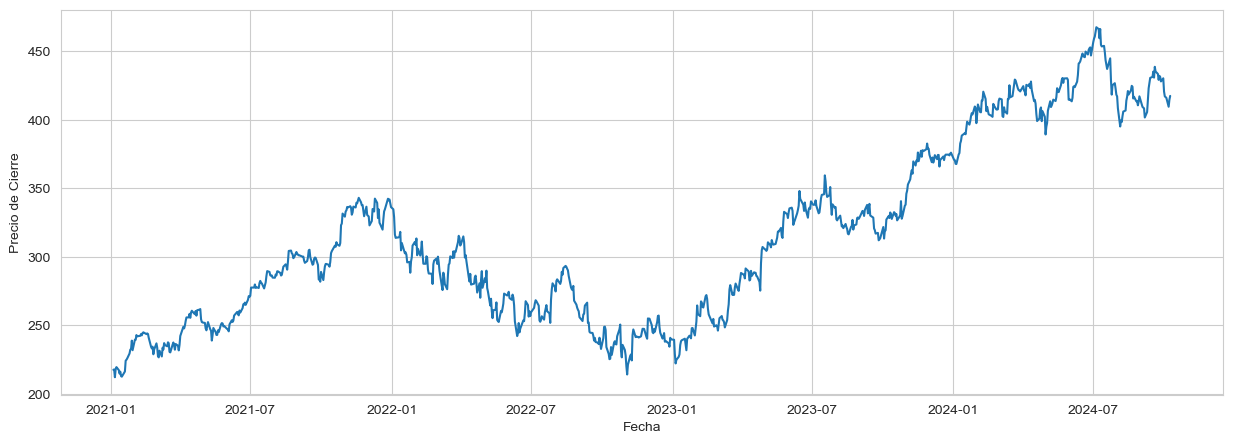

In [82]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=datos, x="Date", y="Close")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre")

## Indicadores Bursatiles


Los indicadores bursátiles son herramientas fundamentales para evaluar el **desempeño de un mercado financiero** o de diversos activos, como acciones, bonos y commodities.

Estos indicadores ofrecen información clave que permite comprender la salud y la dirección del mercado. Inversionistas, analistas financieros y otros profesionales del mercado confían en estos indicadores para tomar decisiones informadas.

En el análisis propuesto, se empleará la biblioteca [Pandas_ta](https://github.com/twopirllc/pandas-ta), que dispone de funciones e indicadores para llevar a cabo análisis técnico.

El resultado de cada indicador será capturado en un DataFrame para su posterior utilización. Además, se presentará de manera visual el comportamiento del indicador, facilitando la interpretación de sus implicaciones en el contexto del análisis.

### Simple Moving Average 

Text(0.5, 0, 'Fecha')

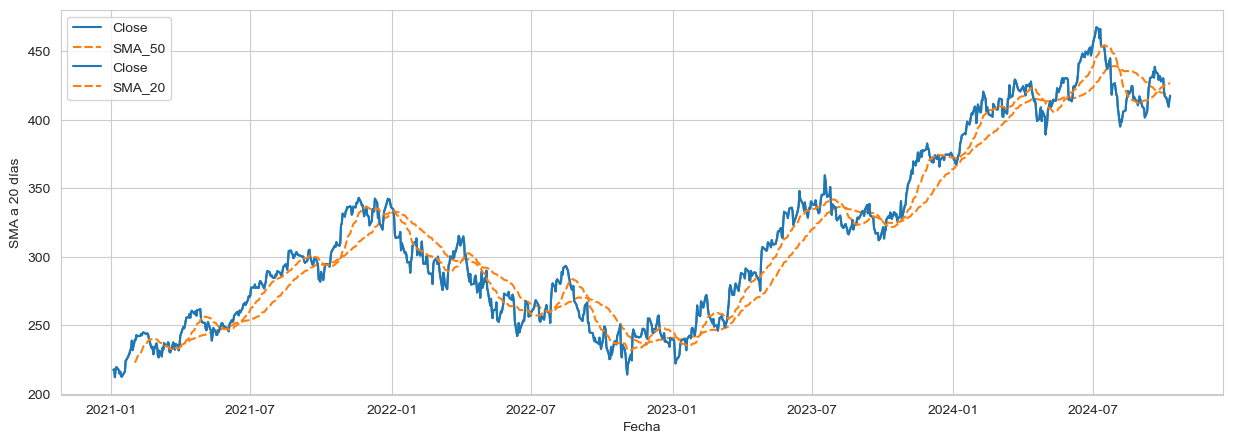

In [83]:
# Se define el indicador
datos["SMA_20"] = ta.sma(datos.Close, length=20)
datos["SMA_50"] = ta.sma(datos.Close, length=50)

# Se define el tamaño del lienzo
plt.figure(figsize=(15,5))

# Se define los valores a graficar
sns.lineplot(data=datos[["Close", "SMA_50"]])
sns.lineplot(data=datos[["Close", "SMA_20"]])

# Se agregan etiquetas de nombres
plt.ylabel("SMA a 50 días")
plt.ylabel("SMA a 20 días")
plt.xlabel("Fecha")

## Average Directional Movement Index

Text(0, 0.5, 'Intervalos')

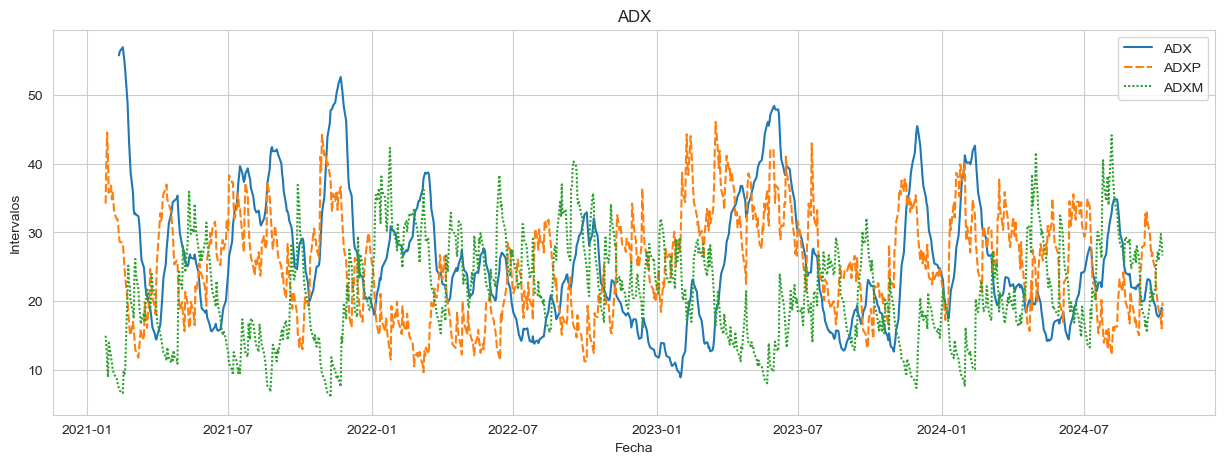

In [84]:
# Se genera el indicador
datos[["ADX", "ADXP", "ADXM"]] = ta.adx(datos["High"], datos["Low"], datos["Close"])

## Se grafica el indicador
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.lineplot(data=datos[["ADX", "ADXP", "ADXM"]], palette="tab10", linewidth=1.5)
plt.title("ADX")
plt.xlabel("Fecha")
plt.ylabel("Intervalos")

##  Absolute Price Oscillator

Text(0.5, 0, 'Fecha')

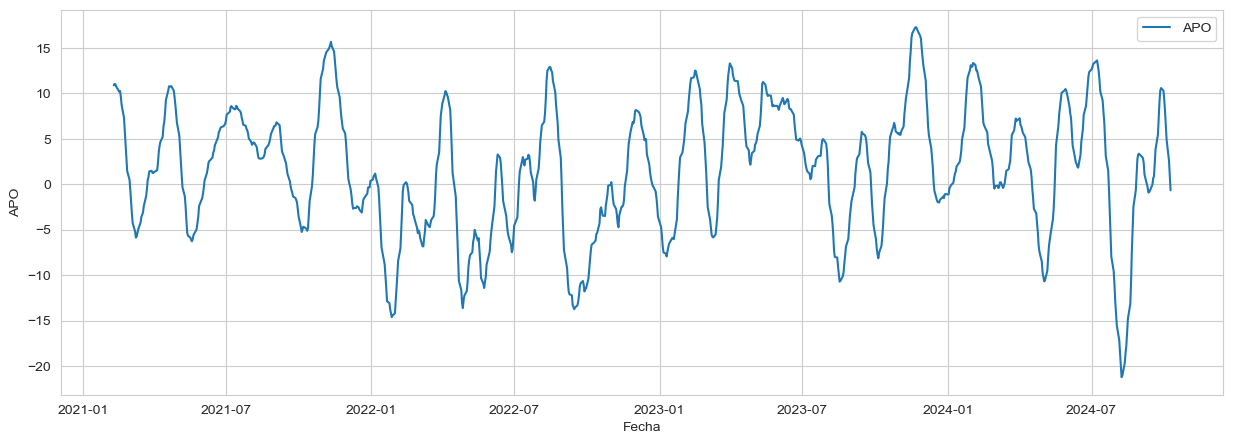

In [85]:
# Se define el indicador
datos["APO"] = ta.apo(datos.Close)

# Se define el tamaño del lienzo
plt.figure(figsize=(15,5))

# Se define los valores a graficar
sns.lineplot(datos[["APO"]])

# Se agregan etiquetas de nombres
plt.ylabel("APO")
plt.xlabel("Fecha")

¿Cómo se intepreta?

`Línea de APO.`

 La línea del APO muestra la diferencia entre dos medias móviles. Si la línea del APO es positiva, significa que la media móvil más corta está por encima de la media móvil más larga, lo que sugiere un impulso alcista. Por otro lado, si la línea del APO es negativa, indica que la media móvil más corta está por debajo de la media móvil más larga, lo que sugiere un impulso bajista.

`Cruces.`

 Los cruces de la línea del APO con la línea cero o con otras líneas de señal pueden utilizarse como señales de compra o venta. Por ejemplo, un cruce ascendente por encima de cero puede considerarse una señal de compra, indicando un cambio potencial hacia un impulso alcista, mientras que un cruce descendente por debajo de cero puede considerarse una señal de venta, indicando un posible cambio hacia un impulso bajista.

## Money Flow Index

Text(0.5, 1.0, 'Money Flow Index')

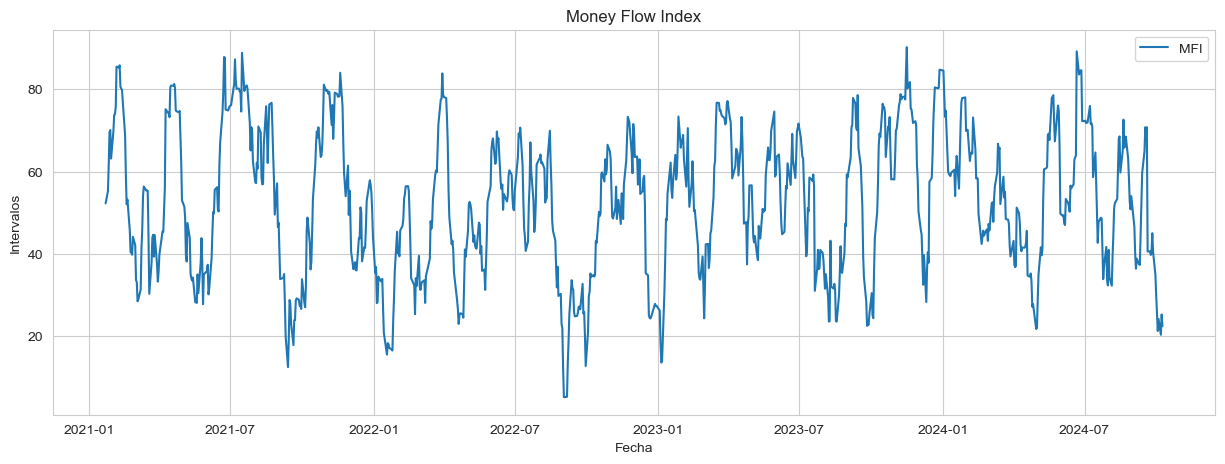

In [86]:
# Se define el indicador
datos["MFI"] = ta.mfi(datos.High, datos.Low, datos.Close, datos.Volume)

# Se define el tamaño del lienzo
plt.figure(figsize=(15,5))

# Se define los valores a graficar
sns.lineplot(datos[["MFI"]])

# Se agregan etiquetas de nombres
plt.ylabel("Intervalos")
plt.xlabel("Fecha")
plt.title("Money Flow Index")

¿Cómo se intepreta?

`Línea de MFI`

Un MFI alto (generalmente por encima de 80) puede indicar que el activo está sobrecomprado y es probable que se produzca una corrección a la baja. Por otro lado, un MFI bajo (generalmente por debajo de 20) puede indicar que el activo está sobrevendido y es probable que se produzca un rebote al alza.

## SAR Parabolic

Text(0, 0.5, 'Precios')

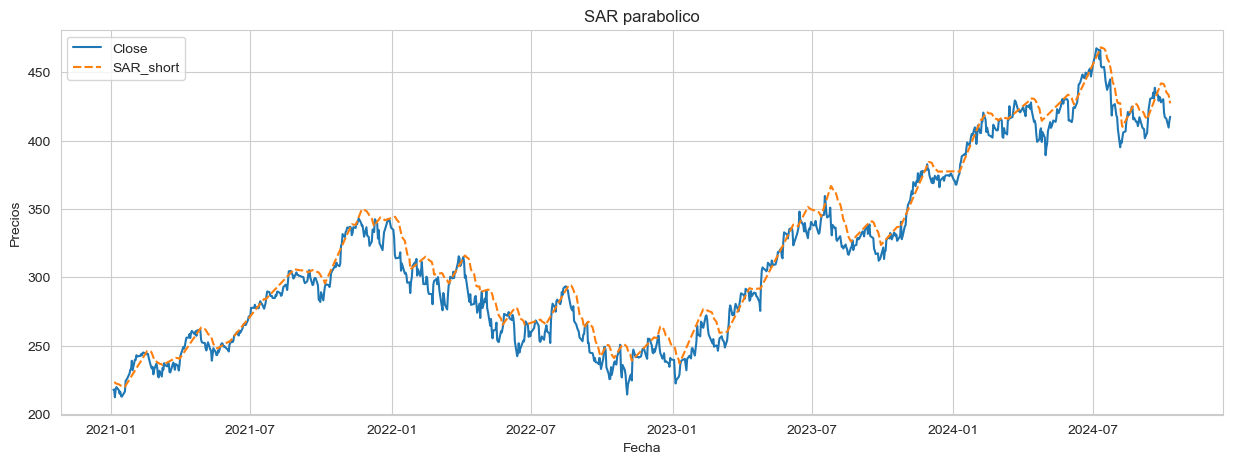

In [87]:
# Se genera el indicador
datos[["SAR_long", "SAR_short", "SAR_af", "SAR_reversed"]] = ta.psar(datos["High"], datos["Low"], datos["Close"])

# Se grafica el indicador
sns.set_style("whitegrid")
plt.figure(figsize=(15,5))
sns.lineplot(data=datos[["Close", "SAR_short"]], palette="tab10", linewidth=1.5)
plt.title("SAR parabolico")
plt.xlabel("Fecha")
plt.ylabel("Precios")

##  Relative Strength Index(RSI)

Text(0.5, 0, 'Fecha')

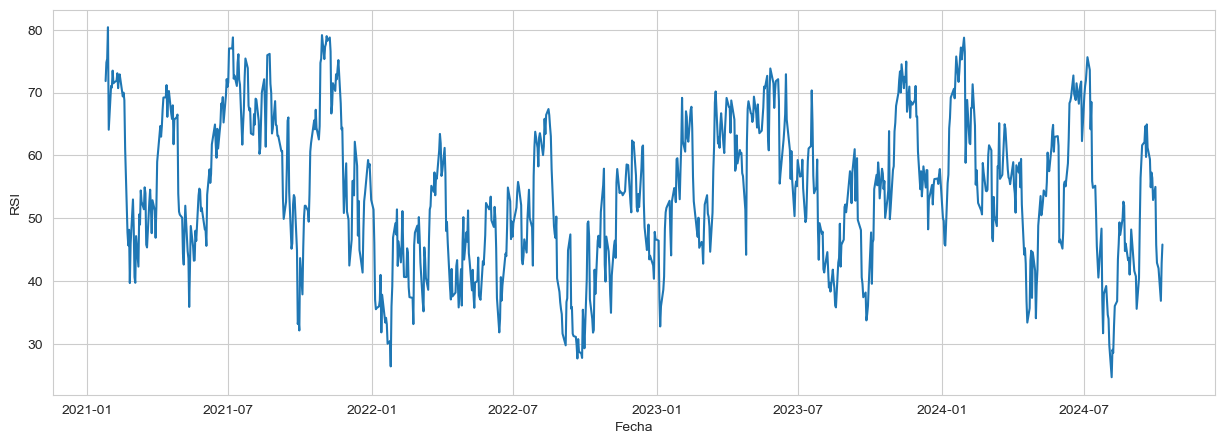

In [88]:
# Se define el indicador
datos["RSI"] = ta.rsi(datos.Close)

# Se define el tamaño del lienzo
plt.figure(figsize=(15,5))

# Se define los valores a graficar
sns.lineplot(data=datos["RSI"])

# Se agregan etiquetas de nombres
plt.ylabel("RSI")
plt.xlabel("Fecha")

`Línea de RSI.`

Un RSI alto (generalmente por encima de 70) puede indicar que el activo está sobrecomprado y es probable que se produzca una corrección a la baja. Por otro lado, un RSI bajo (generalmente por debajo de 30) puede indicar que el activo está sobrevendido y es probable que se produzca un rebote al alza.

## Ultimate Oscillator

Text(0.5, 0, 'Fecha')

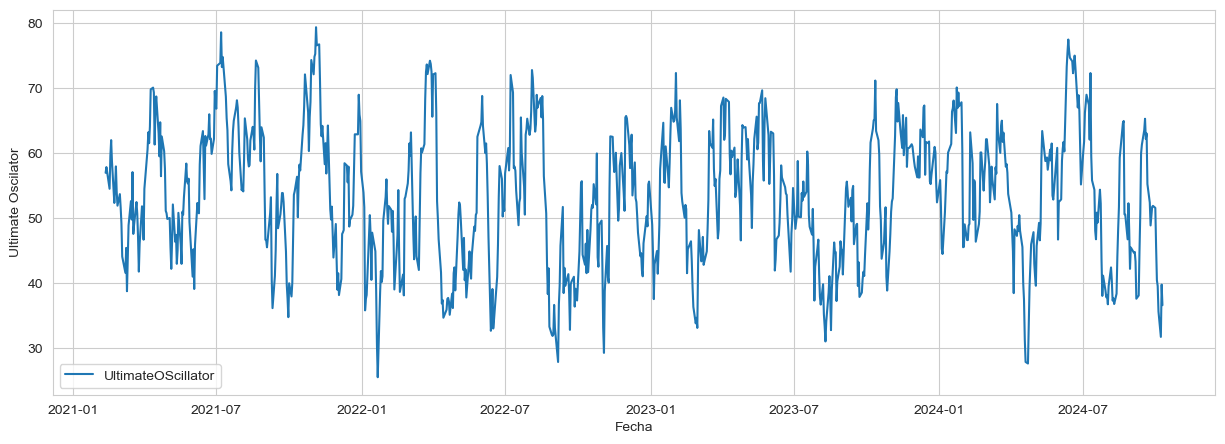

In [89]:
# Se define el indicador
datos["UltimateOScillator"] = ta.uo(datos.High, datos.Low, datos.Close)

# Se define el tamaño del lienzo
plt.figure(figsize=(15,5))

# Se define los valores a graficar
sns.lineplot(data=datos[["UltimateOScillator"]])

# Se agregan etiquetas de nombres
plt.ylabel("Ultimate Oscilator")
plt.xlabel("Fecha")

¿Como se interpreta?

`Valor del Ultimate Oscillator`

Generalmente, se considera que un UO por encima de 70 indica que el activo está sobrecomprado y es probable que se produzca una corrección a la baja, mientras que un UO por debajo de 30 indica que el activo está sobrevendido y es probable que se produzca un rebote al alza.

## Bollinger Bands

Text(0, 0.5, 'Precios')

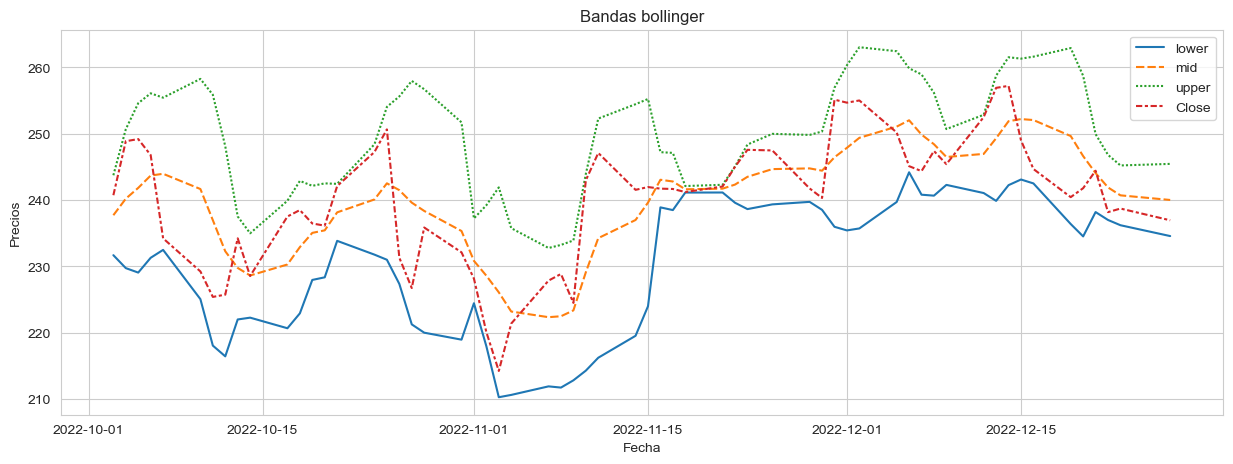

In [90]:
# Se calcula el indicador 
datos[["lower", "mid", "upper", "BANDWIDTH", "Percen"]] = ta.bbands(datos["Close"])


# Se grafica el indicador 
sns.set_style("whitegrid")
plt.figure(figsize=(15,5))
sns.lineplot(data=datos[440:500][["lower", "mid", "upper", "Close"]], palette="tab10", linewidth=1.5)
plt.title("Bandas bollinger")
plt.xlabel("Fecha")
plt.ylabel("Precios")

##  Weighted Moving Average

Text(0.5, 0, 'Fecha')

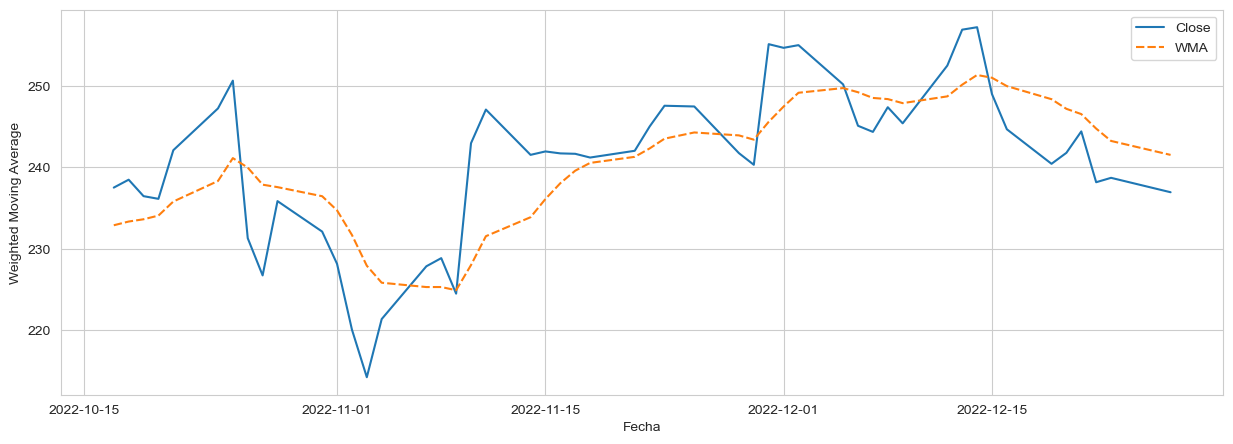

In [91]:
# Se define el indicador
datos["WMA"] = ta.wma(datos.Close)

# Se define el tamaño del lienzo
plt.figure(figsize=(15,5))

# Se define los valores a graficar
sns.lineplot(data=datos[450:500][["Close", "WMA"]])

# Se agregan etiquetas de nombres
plt.ylabel("Weighted Moving Average")
plt.xlabel("Fecha")

¿Cómo se interpreta?

La interpretación de la WMA es similar a la de otras medias móviles, pero con énfasis en los precios más recientes debido a la ponderación que se aplica.

por ejemplo:

`Tendencia`

Cuando la WMA está subiendo, sugiere una tendencia alcista, mientras que cuando está bajando, sugiere una tendencia bajista.

`Indicación de Momentum`.

La pendiente de la WMA puede proporcionar información sobre el impulso del precio. Una WMA inclinada hacia arriba sugiere un impulso alcista, mientras que una WMA inclinada hacia abajo sugiere un impulso bajista.


## Exponential Moving Average 

Text(0.5, 0, 'Fecha')

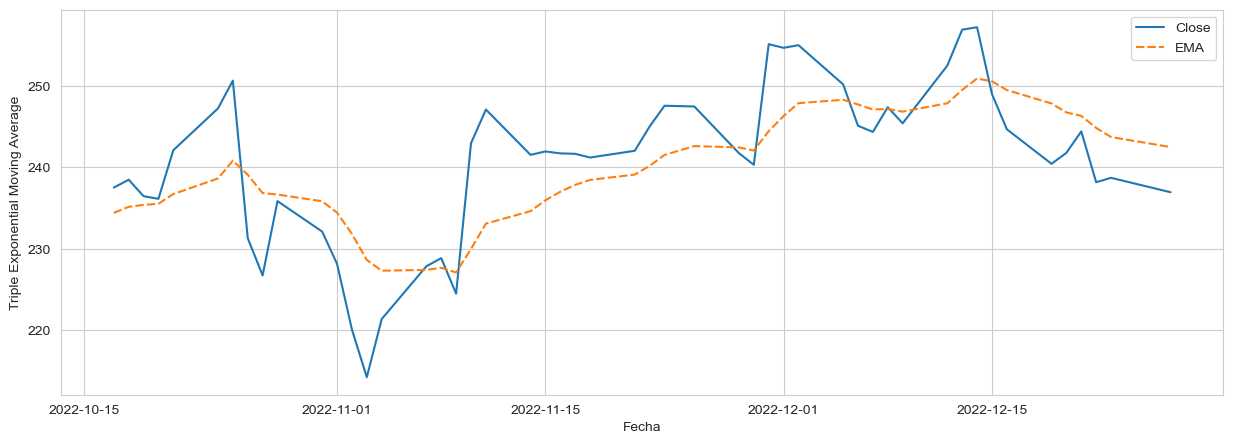

In [92]:
# Se define el indicador
datos["EMA"] = ta.ema(datos.Close)

# Se define el tamaño del lienzo
plt.figure(figsize=(15,5))

# Se define los valores a graficar
sns.lineplot(datos[450:500][["Close", "EMA"]])

# Se agregan etiquetas de nombres
plt.ylabel("Triple Exponential Moving Average")
plt.xlabel("Fecha")

El valor de la EMA actual depende del valor de la EMA anterior y del precio actual. Al tener en cuenta el precio actual con un peso mayor, la EMA reacciona más rápido a los cambios recientes en el precio en comparación con la SMA.

`Tendencia`

Cuando la EMA está subiendo, sugiere una tendencia alcista, mientras que cuando está bajando, sugiere una tendencia bajista.

`Indicación de momentum`

 Una EMA inclinada hacia arriba sugiere un impulso alcista, mientras que una EMA inclinada hacia abajo sugiere un impulso bajista.


## Double Exponential Moving Average

Text(0.5, 0, 'Fecha')

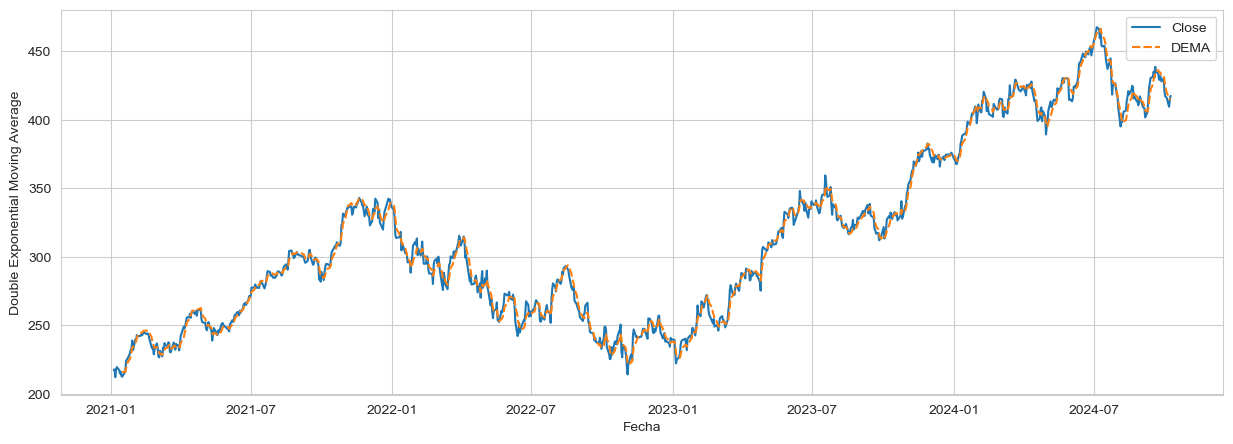

In [93]:
# Se define el indicador
datos["DEMA"] = ta.dema(datos.Close)

# Se define el tamaño del lienzo
plt.figure(figsize=(15,5))

# Se define los valores a graficar
sns.lineplot(datos[["Close", "DEMA"]])

# Se agregan etiquetas de nombres
plt.ylabel("Double Exponential Moving Average")
plt.xlabel("Fecha")

La `DEMA` busca reducir aún más el retraso inherente en las medias móviles al proporcionar una respuesta más rápida a los cambios de precio.

La `DEMA tiende a ser más sensible a los cambios en el precio` en comparación con la EMA tradicional, ya que se calcula mediante un proceso de suavizado doble. Esto significa que puede proporcionar señales de compra o venta más tempranas en comparación con otras medias móviles. Sin embargo, debido a su mayor sensibilidad, la DEMA también puede generar más señales falsas en ciertas condiciones del mercado.

Columna Objetivo.

Se identifica la columna objetivo que se pretende predecir, planteándose la interrogante de si es posible prever si el valor de la acción estará por encima de su promedio móvil en un período de 5 días  

In [94]:
datos

,Close,Open,High,Low,Volume,Date,SMA_20,SMA_50,ADX,ADXP,...,RSI,UltimateOScillator,lower,mid,upper,BANDWIDTH,Percen,WMA,EMA,DEMA
2021-01-04,217.69,222.53,223.0,214.81,10405662,2021-01-04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
2021-01-05,217.9,217.26,218.52,215.7,6537648,2021-01-05,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
2021-01-06,212.25,212.17,216.4899,211.94,7193294,2021-01-06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
2021-01-07,218.29,214.04,219.34,213.71,8054962,2021-01-07,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN
2021-01-08,219.62,218.68,220.58,217.0261,5126757,2021-01-08,NaN,NaN,NaN,NaN,...,NaN,NaN,212.069480,217.150,222.230520,4.679272,0.743085,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-03,416.54,417.63,419.55,414.29,3779256,2024-10-03,425.6145,418.5274,17.830368,19.566894,...,42.437855,39.579274,411.259883,422.536,433.812117,5.337352,0.234128,424.365455,424.438023,422.158415
2024-10-04,416.06,418.24,419.75,414.97,8176758,2024-10-04,426.3325,418.4806,17.687120,18.822807,...,42.030640,35.639635,409.478372,420.144,430.809628,5.077130,0.308544,422.302727,422.914746,419.803295
2024-10-07,409.54,416.0,417.11,409.0,7167047,2024-10-07,426.5235,418.1660,18.317691,17.294295,...,36.857158,31.739864,408.764304,415.992,423.219696,3.474920,0.053661,419.403818,420.482974,415.947609
2024-10-08,414.71,410.9,415.66,408.17,6176405,2024-10-08,426.5490,417.9256,19.001166,16.001883,...,42.862851,39.787642,409.302752,414.796,420.289248,2.648651,0.492172,417.880727,419.433342,414.863800


In [95]:
datos['precios_lead1'] = datos['Close'].shift(-1)
datos['crecimiento'] = np.log(datos['Close'].shift(-1))/np.log(datos['Close'])
datos = datos.dropna(subset=['crecimiento'])
datos["target"] = np.where(datos['crecimiento'] < 1, 0, 1)
datos = datos[50:]

In [96]:
datos

,Close,Open,High,Low,Volume,Date,SMA_20,SMA_50,ADX,ADXP,...,mid,upper,BANDWIDTH,Percen,WMA,EMA,DEMA,precios_lead1,crecimiento,target
2021-03-17,237.04,236.15,238.55,233.23,6666787,2021-03-17,234.0595,231.8768,21.979026,18.423037,...,236.488,238.599015,1.785304,0.630743,235.102182,234.951364,235.812934,230.72,0.995058,0
2021-03-18,230.72,232.56,234.19,230.33,6173625,2021-03-18,233.4060,232.1332,21.233205,16.798650,...,235.206,240.122138,4.180283,0.043748,234.608364,234.182025,234.257487,230.35,0.999705,0
2021-03-19,230.35,231.02,232.474,229.3496,23508852,2021-03-19,232.8750,232.4952,20.779696,16.087367,...,234.126,240.301003,5.274940,0.194251,233.974727,233.485293,232.976981,235.99,1.004447,1
2021-03-22,235.99,230.27,236.9,230.14,9084785,2021-03-22,232.9490,232.8492,19.329273,20.522166,...,234.362,240.711266,5.418341,0.628204,234.389273,233.940695,233.897404,237.58,1.001229,1
2021-03-23,237.58,237.485,241.05,237.07,5962700,2021-03-23,233.1645,233.2084,18.939281,24.673020,...,234.336,240.631047,5.372667,0.757663,234.936545,234.602387,235.108351,235.46,0.998362,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-02,417.13,422.58,422.82,416.71,4746139,2024-10-02,425.2070,418.7746,17.944132,20.638857,...,425.490,436.673524,5.256774,0.126236,426.743636,426.193139,425.162067,416.54,0.999765,0
2024-10-03,416.54,417.63,419.55,414.29,3779256,2024-10-03,425.6145,418.5274,17.830368,19.566894,...,422.536,433.812117,5.337352,0.234128,424.365455,424.438023,422.158415,416.06,0.999809,0
2024-10-04,416.06,418.24,419.75,414.97,8176758,2024-10-04,426.3325,418.4806,17.687120,18.822807,...,420.144,430.809628,5.077130,0.308544,422.302727,422.914746,419.803295,409.54,0.997381,0
2024-10-07,409.54,416.0,417.11,409.0,7167047,2024-10-07,426.5235,418.1660,18.317691,17.294295,...,415.992,423.219696,3.474920,0.053661,419.403818,420.482974,415.947609,414.71,1.002086,1


In [97]:
datos

,Close,Open,High,Low,Volume,Date,SMA_20,SMA_50,ADX,ADXP,...,mid,upper,BANDWIDTH,Percen,WMA,EMA,DEMA,precios_lead1,crecimiento,target
2021-03-17,237.04,236.15,238.55,233.23,6666787,2021-03-17,234.0595,231.8768,21.979026,18.423037,...,236.488,238.599015,1.785304,0.630743,235.102182,234.951364,235.812934,230.72,0.995058,0
2021-03-18,230.72,232.56,234.19,230.33,6173625,2021-03-18,233.4060,232.1332,21.233205,16.798650,...,235.206,240.122138,4.180283,0.043748,234.608364,234.182025,234.257487,230.35,0.999705,0
2021-03-19,230.35,231.02,232.474,229.3496,23508852,2021-03-19,232.8750,232.4952,20.779696,16.087367,...,234.126,240.301003,5.274940,0.194251,233.974727,233.485293,232.976981,235.99,1.004447,1
2021-03-22,235.99,230.27,236.9,230.14,9084785,2021-03-22,232.9490,232.8492,19.329273,20.522166,...,234.362,240.711266,5.418341,0.628204,234.389273,233.940695,233.897404,237.58,1.001229,1
2021-03-23,237.58,237.485,241.05,237.07,5962700,2021-03-23,233.1645,233.2084,18.939281,24.673020,...,234.336,240.631047,5.372667,0.757663,234.936545,234.602387,235.108351,235.46,0.998362,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-02,417.13,422.58,422.82,416.71,4746139,2024-10-02,425.2070,418.7746,17.944132,20.638857,...,425.490,436.673524,5.256774,0.126236,426.743636,426.193139,425.162067,416.54,0.999765,0
2024-10-03,416.54,417.63,419.55,414.29,3779256,2024-10-03,425.6145,418.5274,17.830368,19.566894,...,422.536,433.812117,5.337352,0.234128,424.365455,424.438023,422.158415,416.06,0.999809,0
2024-10-04,416.06,418.24,419.75,414.97,8176758,2024-10-04,426.3325,418.4806,17.687120,18.822807,...,420.144,430.809628,5.077130,0.308544,422.302727,422.914746,419.803295,409.54,0.997381,0
2024-10-07,409.54,416.0,417.11,409.0,7167047,2024-10-07,426.5235,418.1660,18.317691,17.294295,...,415.992,423.219696,3.474920,0.053661,419.403818,420.482974,415.947609,414.71,1.002086,1


In [98]:
# Se define el valor de la columna target
#np.log(datos['Close'][-1] - datos['Close'][-2])
#datos["target_ma"] = datos["Close"].rolling(20).mean() # 1

# Se crea otra columna con valores falso y verdaderos
datos['Signal_20_50'] = np.where(datos['SMA_20'] > datos['SMA_50'], 1.0, 0.0)
datos['Close_s1'] = datos['Close'].shift(1)
datos['lower_s1'] = datos["lower"].shift(1)
datos['upper_s1'] = datos["upper"].shift(1)

datos = datos.dropna(subset=['upper_s1'])

datos['Signal_Boellinger'] = np.where(((datos['Close_s1'] < datos["lower_s1"]) & 
                                       (datos['Close'] > datos["lower"])), 1.0, 0.5)
datos['Signal_Boellinger'] = np.where(((datos['Close_s1'] > datos['upper_s1']) & 
                                       (datos['Close'] < datos["upper"])), 0.0, datos['Signal_Boellinger'])


# Se quitan las columnas que no se necesitan
datos.drop(['SMA_20', 'SMA_50'], axis=1, inplace=True)
datos

,Close,Open,High,Low,Volume,Date,ADX,ADXP,ADXM,APO,...,EMA,DEMA,precios_lead1,crecimiento,target,Signal_20_50,Close_s1,lower_s1,upper_s1,Signal_Boellinger
2021-03-18,230.72,232.56,234.19,230.33,6173625,2021-03-18,21.233205,16.798650,21.450662,-3.130385,...,234.182025,234.257487,230.35,0.999705,0,1.0,237.04,234.376985,238.599015,0.5
2021-03-19,230.35,231.02,232.474,229.3496,23508852,2021-03-19,20.779696,16.087367,21.871036,-2.418269,...,233.485293,232.976981,235.99,1.004447,1,1.0,230.72,230.289862,240.122138,0.5
2021-03-22,235.99,230.27,236.9,230.14,9084785,2021-03-22,19.329273,20.522166,19.907046,-1.319679,...,233.940695,233.897404,237.58,1.001229,1,1.0,230.35,227.950997,240.301003,0.5
2021-03-23,237.58,237.485,241.05,237.07,5962700,2021-03-23,18.939281,24.673020,18.563310,-0.536346,...,234.602387,235.108351,235.46,0.998362,0,0.0,235.99,228.012734,240.711266,0.5
2021-03-24,235.46,237.845,238.0,235.32,3729415,2021-03-24,18.111000,23.758293,20.295969,0.453077,...,234.758316,235.299866,232.34,0.997558,0,0.0,237.58,228.040953,240.631047,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-02,417.13,422.58,422.82,416.71,4746139,2024-10-02,17.944132,20.638857,26.187228,7.980769,...,426.193139,425.162067,416.54,0.999765,0,1.0,420.69,420.220713,436.751287,0.5
2024-10-03,416.54,417.63,419.55,414.29,3779256,2024-10-03,17.830368,19.566894,27.216680,6.326090,...,424.438023,422.158415,416.06,0.999809,0,1.0,417.13,414.306476,436.673524,0.5
2024-10-04,416.06,418.24,419.75,414.97,8176758,2024-10-04,17.687120,18.822807,25.900172,4.886923,...,422.914746,419.803295,409.54,0.997381,0,1.0,416.54,411.259883,433.812117,0.5
2024-10-07,409.54,416.0,417.11,409.0,7167047,2024-10-07,18.317691,17.294295,29.774693,2.595449,...,420.482974,415.947609,414.71,1.002086,1,1.0,416.06,409.478372,430.809628,0.5


In [99]:
datos.isna().sum()

Close                   0
Open                    0
High                    0
Low                     0
Volume                  0
Date                    0
ADX                     0
ADXP                    0
ADXM                    0
APO                     0
MFI                     0
SAR_long              369
SAR_short             527
SAR_af                  0
SAR_reversed            0
RSI                     0
UltimateOScillator      0
lower                   0
mid                     0
upper                   0
BANDWIDTH               0
Percen                  0
WMA                     0
EMA                     0
DEMA                    0
precios_lead1           0
crecimiento             0
target                  0
Signal_20_50            0
Close_s1                0
lower_s1                0
upper_s1                0
Signal_Boellinger       0
dtype: int64

Se elimina las columnas que no se utilizaran

In [100]:
datos = datos.drop(["Date", "SAR_long", "SAR_short", "precios_lead1", "crecimiento", "Close_s1", "lower_s1", "upper_s1"], axis=1)

Se elimina las hileras donde no existan los valores

In [101]:
datos = datos.dropna(axis=1, how='all')

In [102]:
datos = datos.dropna(axis=0, how='any')

## datos

## Prueba y entrenamiento

Se define el conjunto de datos en datos de entrenamiento y de prueba utilizando la funcion train_split_data de sklearn

In [127]:
X_train, X_test, y_train, y_test = train_test_split(datos[datos.columns[5:-1]], # Se selecciona los indicadores, dejando de lado los precios 
                                                    datos.loc[:,"target"], # Se selecciona la columna objetivo
                                                    random_state=42,
                                                    test_size=0.3,
                                                    shuffle=False)

In [129]:
X_train = X_train.drop(["target"], axis=1)
X_test = X_test.drop(["target"], axis=1)

Se define los parametros para el Clasificador

In [130]:
params = {
    "objective" : "binary:logistic",
    "eval_metric" : "logloss",
    "random_state" : 42,
    "learning_rate": 0.05,
    "nthread": -1,
    "max_depth" : 2,
}

Se define el modelo y las metricas de los resultados

In [131]:
clf = xgb.XGBRFClassifier(**params)

clf.fit(
    X_train,
    y_train,
    eval_set = [(X_train, y_train), (X_test, y_test)])

[0]	validation_0-logloss:0.69171	validation_1-logloss:0.69327


XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric='logloss', feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.05, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=2, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None, nthread=-1,
                num_parallel_tree=None, objective='binary:logistic', ...)

In [132]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)

print(" ")
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Training Precision: {train_precision:.2f}")
print(" ")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")

 
Training Accuracy: 0.62
Training Precision: 0.58
 
Test Accuracy: 0.50
Test Precision: 0.59


In [153]:
np.array(y_test.values)

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1])

In [151]:
np.array(y_test_pred)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0])

In [155]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(np.array(y_test.values), np.array(y_test_pred), pos_label=2)
tpr
#metrics.auc(fpr, tpr)

array([nan, nan, nan])

In [156]:
from sklearn.metrics import recall_score

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)
print(" ")
print(f"Training Recall: {train_recall:.2f}")
print(f"Test Recall: {test_recall:.2f}")

 
Training Recall: 0.86
Test Recall: 0.23


Se grafica el nivel de importancia de cada indicador dentro del modelo

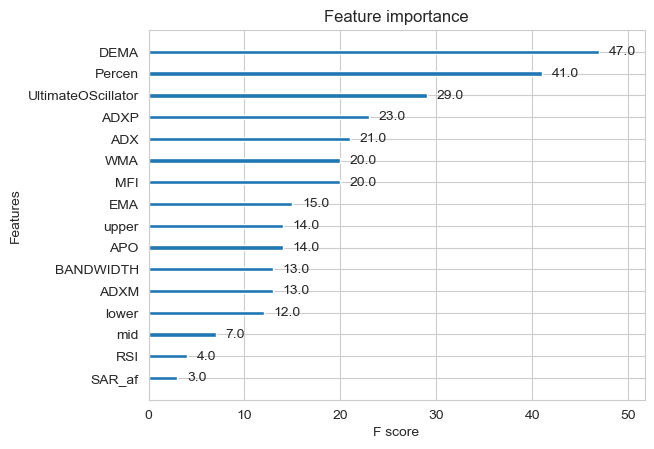

In [157]:
xgb.plot_importance(clf, importance_type="weight")
plt.show()

<Axes: >

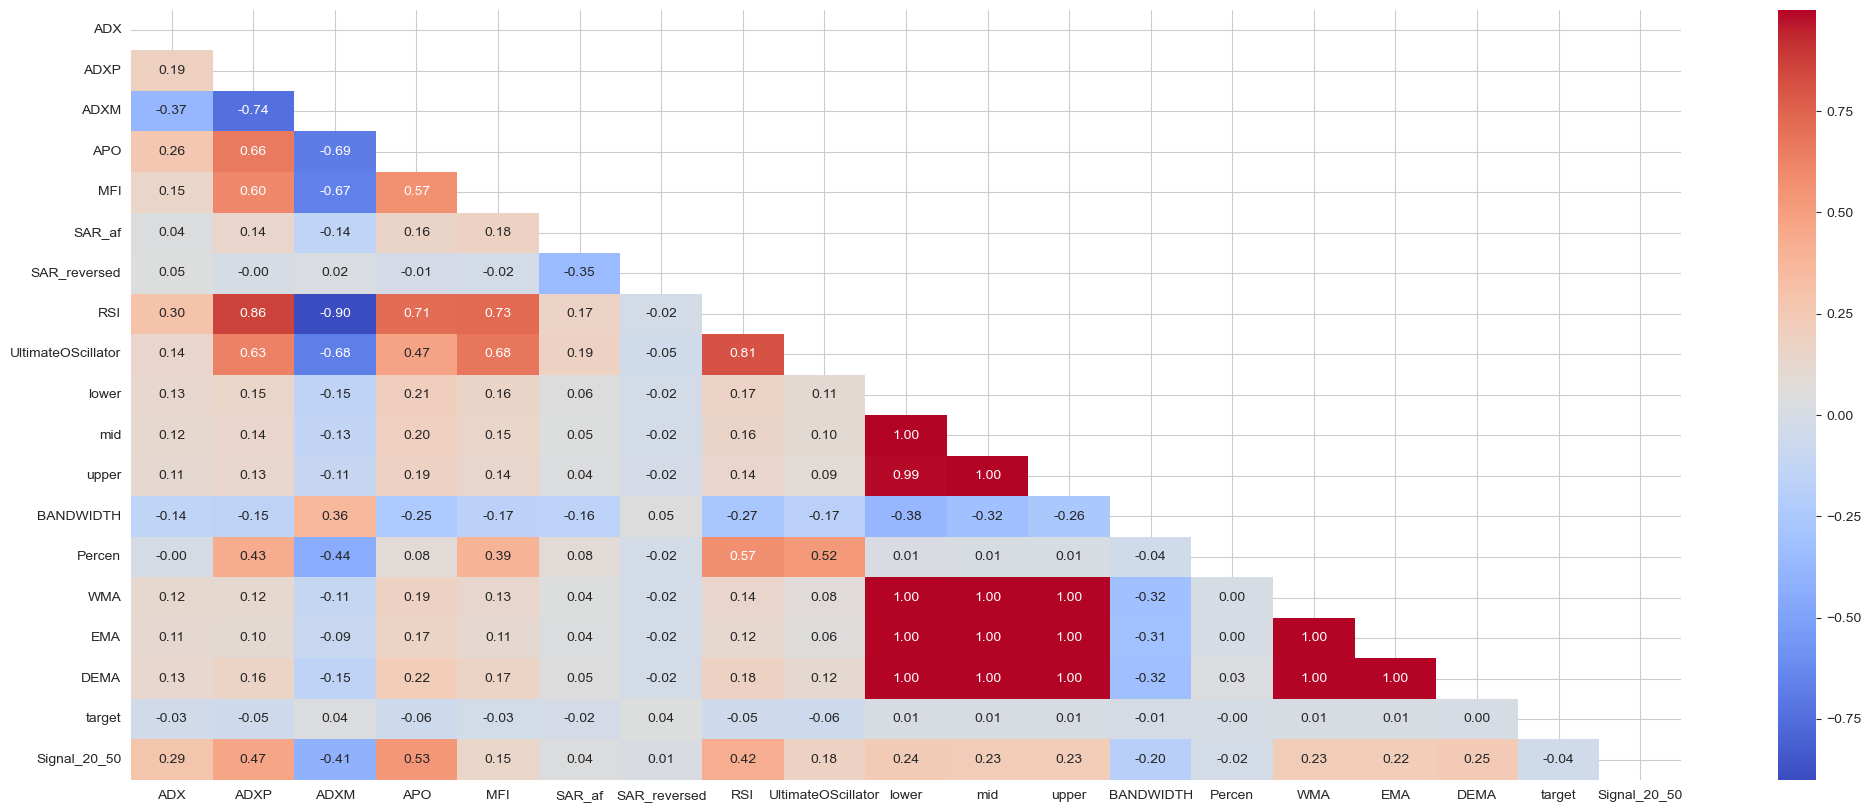

In [158]:
# Se define la matriz de datos
corr_matrix = datos[datos.columns[5:-1]].corr()

# Se grafica la matriz 
plt.figure(figsize=(25, 10))
mask = np.triu(np.ones_like(corr_matrix.abs(), dtype=bool))
tri_df = corr_matrix.mask(mask)
sns.heatmap(tri_df, annot=True, cmap="coolwarm", fmt= ".2f")

## Re-entrenamiento

Después de analizar la matriz de correlación, se procederá a reentrenar el modelo.

En este proceso de entrenamiento del nuevo modelo, se excluirán aquellas variables que presenten una correlación superior al 85%.

In [159]:
# Se encuentra las variables con una correlacion mayor a 0.85
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.85)] # variables con correlacion

# Se retira las variables encontradas
datos.drop(to_drop, axis=1, inplace=True)

# Se explora las variables restantes
print(f"Las variables restantes son:{datos.columns}")

# Se checa cuales son las variables que se retiraron
print(f"Las variables que se retiraron son:{to_drop}")

Las variables restantes son:Index(['Close', 'Open', 'High', 'Low', 'Volume', 'ADX', 'ADXM', 'APO', 'MFI',
       'SAR_af', 'SAR_reversed', 'RSI', 'UltimateOScillator', 'BANDWIDTH',
       'Percen', 'DEMA', 'target', 'Signal_20_50', 'Signal_Boellinger'],
      dtype='object')
Las variables que se retiraron son:['ADXP', 'lower', 'mid', 'upper', 'WMA', 'EMA']


Se mantiene los nuevos parametros de entrenamiento y se vuelve a definir el modelo ahora con las variables restantes

In [165]:
X_train, X_test, y_train, y_test = train_test_split(datos[datos.columns[5:-1]],
                                                    datos.loc[:,"target"],
                                                    random_state=42,
                                                    test_size=0.3,
                                                    shuffle=False)

X_train = X_train.drop(["target"], axis=1)
X_test = X_test.drop(["target"], axis=1)

In [166]:
clf = xgb.XGBRFClassifier(**params)

clf.fit(
    X_train,
    y_train,
    eval_set = [(X_train, y_train), (X_test, y_test)]
)

[0]	validation_0-logloss:0.69173	validation_1-logloss:0.69321


XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric='logloss', feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.05, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=2, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None, nthread=-1,
                num_parallel_tree=None, objective='binary:logistic', ...)

In [167]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)

print(" ")
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Training Precision: {train_precision:.2f}")
print(" ")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")

 
Training Accuracy: 0.62
Training Precision: 0.58
 
Test Accuracy: 0.50
Test Precision: 0.58


Certeza = accuracy

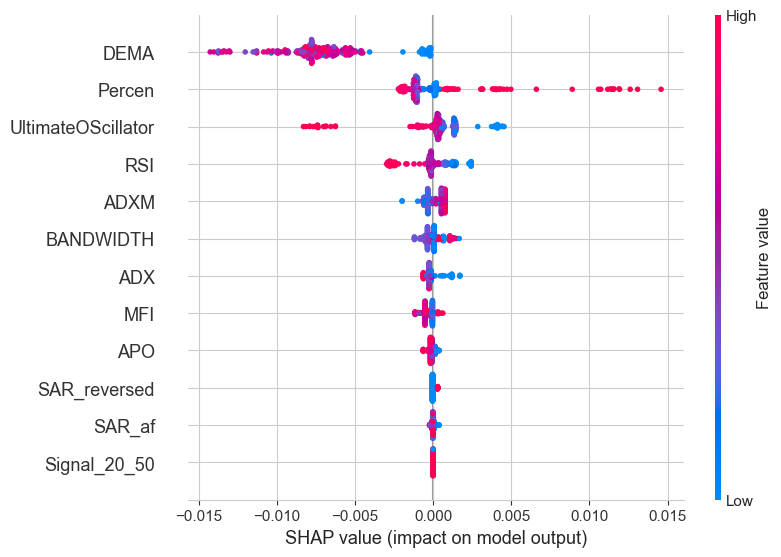

In [168]:
# Se define la variable con la funcion que ayuda a describir el modelo
explainer = shap.TreeExplainer(clf)

explanation = explainer(X_test)
shap_values = explanation.values

shap.plots.beeswarm(explanation, max_display=len(datos.columns))

Se puede tomar una fecha aleatoria y ver como es el impacto de cada uno de los indicadores en el precio de mercado en un determinado instante.

In [171]:
X_test2 = X_test.reset_index()
X_test2

,index,ADX,ADXM,APO,MFI,SAR_af,SAR_reversed,RSI,UltimateOScillator,BANDWIDTH,Percen,DEMA,Signal_20_50
0,2023-09-14,19.343639,14.867728,5.756282,78.583242,0.14,0,59.563357,54.974598,2.996264,0.793442,336.871215,0.0
1,2023-09-15,18.312705,21.398689,5.599808,65.711012,0.02,1,49.729316,46.006686,4.022314,0.149799,335.200516,0.0
2,2023-09-18,17.286671,24.310523,5.386538,61.359390,0.04,0,48.548518,49.000148,4.378132,0.218777,333.533999,0.0
3,2023-09-19,16.667685,25.117604,5.166859,56.619326,0.06,0,48.113666,49.136120,4.899710,0.261376,332.134958,0.0
4,2023-09-20,16.757034,27.130048,4.635128,51.240624,0.08,0,40.588790,39.569164,6.916488,0.117789,328.478246,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,2024-10-02,17.944132,26.187228,7.980769,25.828305,0.08,0,42.912388,40.454271,5.256774,0.126236,425.162067,1.0
265,2024-10-03,17.830368,27.216680,6.326090,21.287460,0.10,0,42.437855,39.579274,5.337352,0.234128,422.158415,1.0
266,2024-10-04,17.687120,25.900172,4.886923,24.198772,0.10,0,42.030640,35.639635,5.077130,0.308544,419.803295,1.0
267,2024-10-07,18.317691,29.774693,2.595449,20.365699,0.12,0,36.857158,31.739864,3.474920,0.053661,415.947609,1.0


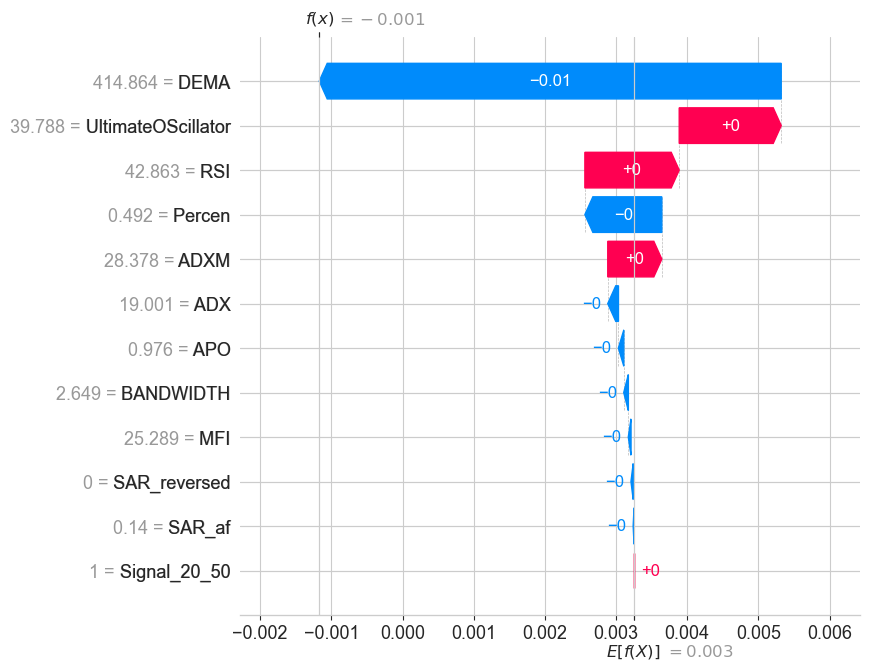

In [172]:
# Se genera un nuevo dataframe con el indice como columna
X_test2 = X_test.reset_index()

# Se toma el valor en la fecha especifica
idx = X_test2.loc[X_test2["index"] == "2024-10-08"].index[0]

# Se espeficica el valor dentro del parametro explanation
shap.plots.waterfall(explanation[idx], max_display=len(datos.columns))